# Run scDeepCluster on 10X PBMC dataset 

This tutorial was implemented on Macbook pro CPU.

In [1]:
from time import time
import math, os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from scDeepCluster import scDeepCluster
from single_cell_tools import *
import numpy as np
from sklearn import metrics
import h5py
import scanpy as sc
from preprocess import read_dataset, normalize

In [2]:
# for repeatability
torch.manual_seed(42)

Setup parameters.

In [3]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.n_clusters = 0
        self.knn = 20
        self.resolution = 0.8
        self.select_genes = 0
        self.batch_size = 256
        self.data_file = '10X_PBMC.h5'
        self.maxiter = 2000
        self.pretrain_epochs = 300
        self.gamma = 1.
        self.sigma = 2.5
        self.update_interval = 1
        self.tol = 0.001
        self.ae_weights = None
        self.save_dir = 'results/scDeepCluster/'
        self.ae_weight_file = 'AE_weights.pth.tar'
        self.final_latent_file = 'final_latent_file.txt'
        self.predict_label_file = 'pred_labels.txt'
        self.device = 'cpu'

args = Args()

Normalizating and preprocessing count data.

In [4]:
data_mat = h5py.File(args.data_file)
x = np.array(data_mat['X'])
# y is the ground truth labels for evaluating clustering performance
# If not existing, we skip calculating the clustering performance metrics (e.g. NMI ARI)
if 'Y' in data_mat:
    y = np.array(data_mat['Y'])
else:
    y = None
data_mat.close()

if args.select_genes > 0:
    importantGenes = geneSelection(x, n=args.select_genes, plot=False)
    x = x[:, importantGenes]

# preprocessing scRNA-seq read counts matrix
adata = sc.AnnData(x)
if y is not None:
    adata.obs['Group'] = y

adata = read_dataset(adata,
                 transpose=False,
                 test_split=False,
                 copy=True)

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

input_size = adata.n_vars

print(args)

print(adata.X.shape)
if y is not None:
    print(y.shape)

### Autoencoder: Successfully preprocessed 16653 genes and 4271 cells.


/usr/local/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(4271, 16653)
(4271,)


Build scDeepCluster model

In [5]:
model = scDeepCluster(input_dim=adata.n_vars, z_dim=32, 
            encodeLayer=[256, 64], decodeLayer=[64, 256], sigma=args.sigma, gamma=args.gamma, device=args.device)

print(str(model))

scDeepCluster(
  (encoder): Sequential(
    (0): Linear(in_features=16653, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
  )
  (_enc_mu): Linear(in_features=64, out_features=32, bias=True)
  (_dec_mean): Sequential(
    (0): Linear(in_features=256, out_features=16653, bias=True)
    (1): MeanAct()
  )
  (_dec_disp): Sequential(
    (0): Linear(in_features=256, out_features=16653, bias=True)
    (1): DispAct()
  )
  (_dec_pi): Sequential(
    (0): Linear(in_features=256, out_features=16653, bias=True)
    (1): Sigmoid()
  )
  (zinb_loss): ZINBLoss()
)


Pretraining stage.

In [6]:
t0 = time()
if args.ae_weights is None:
    model.pretrain_autoencoder(X=adata.X, X_raw=adata.raw.X, size_factor=adata.obs.size_factors, 
                            batch_size=args.batch_size, epochs=args.pretrain_epochs, ae_weights=args.ae_weight_file)
else:
    if os.path.isfile(args.ae_weights):
        print("==> loading checkpoint '{}'".format(args.ae_weights))
        checkpoint = torch.load(args.ae_weights)
        model.load_state_dict(checkpoint['ae_state_dict'])
    else:
        print("==> no checkpoint found at '{}'".format(args.ae_weights))
        raise ValueError

print('Pretraining time: %d seconds.' % int(time() - t0))


Pretraining stage
Pretrain epoch   1, ZINB loss: 0.38624983
Pretrain epoch   2, ZINB loss: 0.27462633
Pretrain epoch   3, ZINB loss: 0.25858435
Pretrain epoch   4, ZINB loss: 0.25226691
Pretrain epoch   5, ZINB loss: 0.24892684
Pretrain epoch   6, ZINB loss: 0.24629810
Pretrain epoch   7, ZINB loss: 0.24442891
Pretrain epoch   8, ZINB loss: 0.24262825
Pretrain epoch   9, ZINB loss: 0.24122619
Pretrain epoch  10, ZINB loss: 0.24002783
Pretrain epoch  11, ZINB loss: 0.23928566
Pretrain epoch  12, ZINB loss: 0.23838483
Pretrain epoch  13, ZINB loss: 0.23762305
Pretrain epoch  14, ZINB loss: 0.23711647
Pretrain epoch  15, ZINB loss: 0.23650192
Pretrain epoch  16, ZINB loss: 0.23605568
Pretrain epoch  17, ZINB loss: 0.23581944
Pretrain epoch  18, ZINB loss: 0.23543888
Pretrain epoch  19, ZINB loss: 0.23522856
Pretrain epoch  20, ZINB loss: 0.23499573
Pretrain epoch  21, ZINB loss: 0.23501381
Pretrain epoch  22, ZINB loss: 0.23471009
Pretrain epoch  23, ZINB loss: 0.23455623
Pretrain epoch  

Pretrain epoch 196, ZINB loss: 0.22281503
Pretrain epoch 197, ZINB loss: 0.22263191
Pretrain epoch 198, ZINB loss: 0.22256174
Pretrain epoch 199, ZINB loss: 0.22243141
Pretrain epoch 200, ZINB loss: 0.22252310
Pretrain epoch 201, ZINB loss: 0.22236248
Pretrain epoch 202, ZINB loss: 0.22244692
Pretrain epoch 203, ZINB loss: 0.22217898
Pretrain epoch 204, ZINB loss: 0.22209356
Pretrain epoch 205, ZINB loss: 0.22210407
Pretrain epoch 206, ZINB loss: 0.22195778
Pretrain epoch 207, ZINB loss: 0.22193105
Pretrain epoch 208, ZINB loss: 0.22195967
Pretrain epoch 209, ZINB loss: 0.22182915
Pretrain epoch 210, ZINB loss: 0.22169341
Pretrain epoch 211, ZINB loss: 0.22163370
Pretrain epoch 212, ZINB loss: 0.22177499
Pretrain epoch 213, ZINB loss: 0.22147643
Pretrain epoch 214, ZINB loss: 0.22148880
Pretrain epoch 215, ZINB loss: 0.22136244
Pretrain epoch 216, ZINB loss: 0.22121936
Pretrain epoch 217, ZINB loss: 0.22130410
Pretrain epoch 218, ZINB loss: 0.22126952
Pretrain epoch 219, ZINB loss: 0.2

Clustering stage.

In [7]:
if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

if args.n_clusters > 0:
    y_pred, _, _, _, _ = model.fit(X=adata.X, X_raw=adata.raw.X, size_factor=adata.obs.size_factors, n_clusters=args.n_clusters, init_centroid=None, 
                y_pred_init=None, y=y, batch_size=args.batch_size, num_epochs=args.maxiter, update_interval=args.update_interval, tol=args.tol, save_dir=args.save_dir)
else:
    ### estimate number of clusters by Louvain algorithm on the autoencoder latent representations
    pretrain_latent = model.encodeBatch(torch.tensor(adata.X)).cpu().numpy()
    adata_latent = sc.AnnData(pretrain_latent)
    sc.pp.neighbors(adata_latent, n_neighbors=args.knn, use_rep="X")
    sc.tl.louvain(adata_latent, resolution=args.resolution)
    y_pred_init = np.asarray(adata_latent.obs['louvain'],dtype=int)
    features = pd.DataFrame(adata_latent.X,index=np.arange(0,adata_latent.n_obs))
    Group = pd.Series(y_pred_init,index=np.arange(0,adata_latent.n_obs),name="Group")
    Mergefeature = pd.concat([features,Group],axis=1)
    cluster_centers = np.asarray(Mergefeature.groupby("Group").mean())
    n_clusters = cluster_centers.shape[0]
    print('Estimated number of clusters: ', n_clusters)
    y_pred, _, _, _, _ = model.fit(X=adata.X, X_raw=adata.raw.X, size_factor=adata.obs.size_factors, n_clusters=n_clusters, init_centroid=cluster_centers, 
                y_pred_init=y_pred_init, y=y, batch_size=args.batch_size, num_epochs=args.maxiter, update_interval=args.update_interval, tol=args.tol, save_dir=args.save_dir)


print('Total time: %d seconds.' % int(time() - t0))

Estimated number of clusters:  8
Clustering stage
Initializing cluster centers with kmeans.
Initializing k-means: NMI= 0.7540, ARI= 0.7166
Clustering   1: NMI= 0.7699, ARI= 0.7444
Epoch   1: Total: 0.43260478 Clustering Loss: 0.14155029 ZINB Loss: 0.29105450
Clustering   2: NMI= 0.7712, ARI= 0.7417
Epoch   2: Total: 0.48279577 Clustering Loss: 0.22362547 ZINB Loss: 0.25917030
Clustering   3: NMI= 0.7818, ARI= 0.7417
Epoch   3: Total: 0.46994593 Clustering Loss: 0.21151713 ZINB Loss: 0.25842881
Clustering   4: NMI= 0.7711, ARI= 0.7330
Epoch   4: Total: 0.53531363 Clustering Loss: 0.27772831 ZINB Loss: 0.25758532
Clustering   5: NMI= 0.7948, ARI= 0.7612
Epoch   5: Total: 0.46937219 Clustering Loss: 0.21545971 ZINB Loss: 0.25391249
Clustering   6: NMI= 0.7862, ARI= 0.7506
Epoch   6: Total: 0.46948462 Clustering Loss: 0.21145260 ZINB Loss: 0.25803201
Clustering   7: NMI= 0.7951, ARI= 0.7649
Epoch   7: Total: 0.49165614 Clustering Loss: 0.24132139 ZINB Loss: 0.25033475
Clustering   8: NMI= 

Output and save predicted labels and latent features.

In [8]:
if y is not None:
    #    acc = np.round(cluster_acc(y, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
    print('Evaluating cells: NMI= %.4f, ARI= %.4f' % (nmi, ari))

final_latent = model.encodeBatch(torch.tensor(adata.X)).cpu().numpy()
np.savetxt(args.final_latent_file, final_latent, delimiter=",")
np.savetxt(args.predict_label_file, y_pred, delimiter=",", fmt="%i")

Evaluating cells: NMI= 0.7855, ARI= 0.7470


Run t-SNE on latent features.

In [9]:
from openTSNE import TSNE

tsne_embedding = TSNE(
                    perplexity=30,
                    initialization="pca",
                    metric="euclidean",
                    n_jobs=8,
                    random_state=42,
                )
latent_tsne_2 = tsne_embedding.fit(final_latent)
np.savetxt("tsne_2D.txt", latent_tsne_2, delimiter=",")

Plot 2D t-SNE of latent features

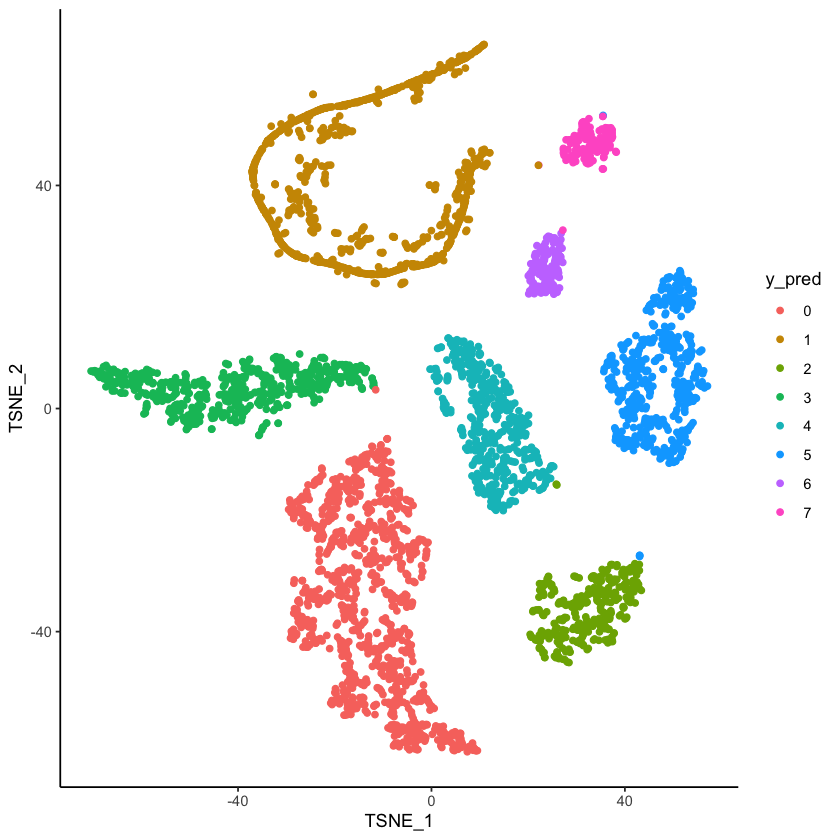

In [4]:
rm(list = ls())
library(ggplot2)

latent_tsne <- read.table("tsne_2D.txt", sep=",")
colnames(latent_tsne) <- c("TSNE_1", "TSNE_2")
y_pred <- as.numeric(readLines("pred_labels.txt"))
y_pred <- factor(y_pred, levels=0:max(y_pred))

dat <- data.frame(latent_tsne, y_pred=y_pred)

ggplot(dat, aes(x=TSNE_1, y=TSNE_2, color=y_pred)) + geom_point() + theme_classic()